In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from photutils import SkyEllipticalAperture, aperture_photometry
from matplotlib.ticker import MultipleLocator
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

/tmp/ipykernel_8363/3450304999.py:8: DeprecationWarning: `photutils.SkyEllipticalAperture` is a deprecated alias for `photutils.aperture.SkyEllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyEllipticalAperture` to silence this warning.
  from photutils import SkyEllipticalAperture, aperture_photometry
/tmp/ipykernel_8363/3450304999.py:8: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import SkyEllipticalAperture, aperture_photometry


In [2]:
GALEX_file = "GI6_012039_HRS74_75-nd-int.fits.gz"
flux_ext_nuv_factor = 'flux_ext_nuv_factor.fits'

centre = SkyCoord('11:56:28.1445516072 +55:07:30.859586652', frame='icrs', unit=(u.hour, u.deg)) #from simbad
x_c = centre.ra.degree   
y_c = centre.dec.degree 
figname = 'corrected_annuli_averaged_values.png'
one_arcmin_in_kpc = 0.076 * 60 # z = 0.003710 from NED

axis_ratio = 1 / 0.901  #axis ratio (major axis/minor axis)
theta = 14.50  #deg; Major axis position angle (North Eastwards)
step_size = 1.5 / 60 #Numerator is in arcseconds 
till_here = 2 / one_arcmin_in_kpc # Numerator is in kpc
tick_sep = 0.5

In [3]:
def arcminute_to_kpc(arcminute):
    kpc = arcminute * one_arcmin_in_kpc
    kpc = np.round(kpc, 1)
    # return kpc.astype(np.int64)
    return kpc


def arcsec_to_kpc(arcsec):
    kpc = arcsec * one_arcsec_in_kpc
    kpc = np.round(kpc, 1)
    # return kpc.astype(np.int64)
    return kpc.astype(np.int64)

# from https://kavigupta.org/2019/05/18/Setting-the-size-of-figures-in-matplotlib/
def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False
        
# foreground extinction correction
def cardelli1989(Rv, Av, UV_lambda_in_A):
    
    x = 1e4 / UV_lambda_in_A
    
    if 8 >= x >= 5.9:
        Fa = -0.04473 * (x - 5.9) ** 2 - 0.009779 * (x - 5.9) ** 3
        Fb =  0.21300 * (x - 5.9) ** 2 + 0.120700 * (x - 5.9) ** 3
    elif 5.9 > x >= 3.3:
        Fa = 0
        Fb = 0
    else:
        print('Outside the range of acceptable values')
        return
    
    a =  1.752 - 0.316 * x - 0.104 / ((x - 4.67) ** 2 + 0.341) + Fa
    b = -3.090 + 1.825 * x + 1.206 / ((x - 4.62) ** 2 + 0.263) + Fb

    A_lambda = (a + (b / Rv)) * Av # To subtract
    flux_ext = 10 ** (0.4 * A_lambda) # To multiply
    return A_lambda, flux_ext

In [4]:
Rv = 3.1 # Assumed Rv.
Av = 0.0437 # Measured galactic extinction ADS/IRSA.Dust#2022/0417/005659_2446 Schlegel et al. 1998 (ApJ 500, 525)
GALEX_NUV_lambda = 2304.74   # Angstrom

_, foreground_ext_factor = cardelli1989(Rv, Av, GALEX_NUV_lambda)

In [5]:
hdu = fits.open(GALEX_file)

# background 
bg_median = 0.00225428
bg_std = 0.000998583
z_data = hdu[0].data - bg_median

# To flux
z_data = z_data * 2.06 * 1e-16

# Correcting flux for extinction
z_data = z_data * foreground_ext_factor

wcs = WCS(hdu[0].header)

att_hdu = fits.open(flux_ext_nuv_factor)
att_data = att_hdu[0].data
att_wcs = WCS(att_hdu[0].header)

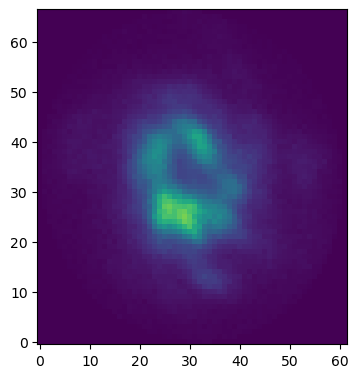

In [6]:
test_a = 50.* u.arcsec
test_b =  test_a / axis_ratio 
position = SkyCoord(x_c, y_c, frame='icrs', unit='deg')
test_aperture = SkyEllipticalAperture(position, test_a, test_b, theta * u.deg)
test_pixel_aperture = test_aperture.to_pixel(wcs = wcs)
test_mask = test_pixel_aperture.to_mask(method='center')
plt.figure(figsize = [4, 4 * axis_ratio])
plt.imshow(test_mask.multiply(hdu[0].data), 
           origin = 'lower', 
           vmin = 0, 
           vmax = 1)

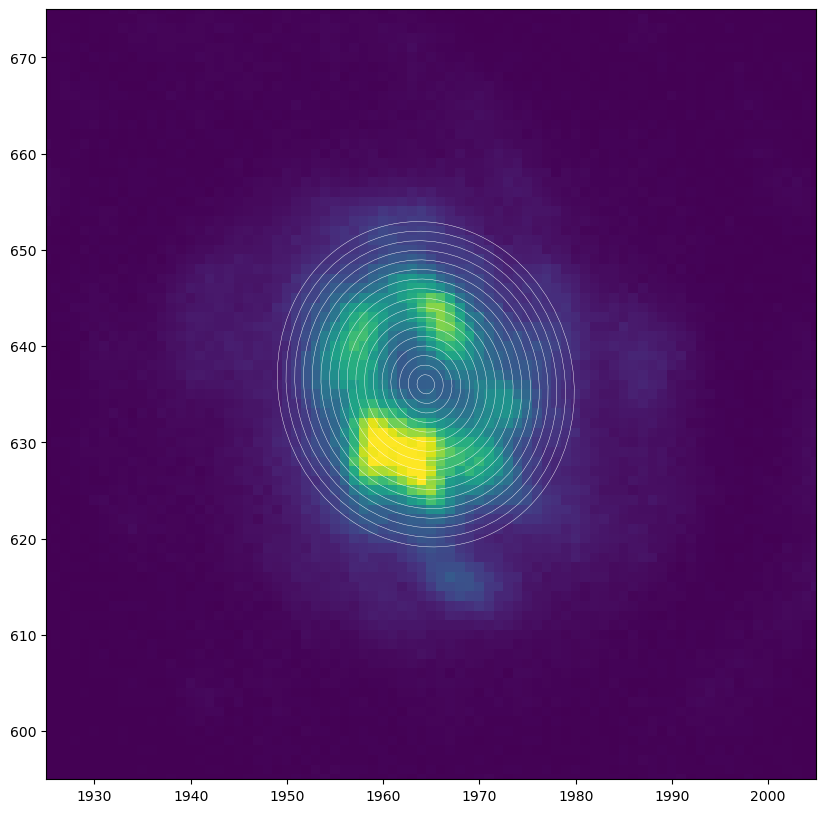

In [7]:
# To plot the data
plt.figure(figsize = [10, 10])
plt.imshow(z_data, 
           origin = 'lower', 
           vmin = 0.0, 
           vmax = 0.8 * 2.06 * 1e-16)

plt.xlim(1925, 2005)
plt.ylim(595, 675)

# To get values of data within concentric circles.
z_ellipse_flux = []
z_nonzero_pixels = []
z_ellipse_area = []

position = SkyCoord(x_c, y_c, frame = 'icrs', unit = 'deg')
axes_values = np.arange(step_size, till_here, step_size)

for minor_axis in axes_values:
    a = minor_axis * u.arcminute
    b = a / axis_ratio 
    sky_aperture = SkyEllipticalAperture(position, a, b, theta * u.deg)
    pixel_aperture = sky_aperture.to_pixel(wcs = wcs)
    pixel_aperture.plot(color='white', lw=0.3)
    mask = pixel_aperture.to_mask(method='center')
    z_masked_data = mask.multiply(z_data)
    # z_ellipse_flux.append(np.sum(z_masked_data))
    
    phot_table = aperture_photometry(z_data, sky_aperture, wcs = wcs)    
    z_ellipse_flux.append(phot_table['aperture_sum'].value[0])
    
    z_nonzero_pixels.append(np.sum(z_masked_data != 0))
    z_ellipse_area.append(pixel_aperture.area)

att_ellipse_flux = []
att_nonzero_pixels = []
att_ellipse_area = []

att_axes_values = np.arange(step_size, 0.22, step_size)
    
for minor_axis in att_axes_values:
    a = minor_axis * u.arcminute
    b = a / axis_ratio 
    sky_aperture = SkyEllipticalAperture(position, a, b, theta * u.deg)
    pixel_aperture = sky_aperture.to_pixel(wcs = att_wcs)
    # pixel_aperture.plot(color='red', lw=0.3)
    mask = pixel_aperture.to_mask(method='center')
    att_masked_data = mask.multiply(att_data)
    # att_ellipse_flux.append(np.sum(att_masked_data))

    phot_table = aperture_photometry(att_data, sky_aperture, wcs = att_wcs)    
    att_ellipse_flux.append(phot_table['aperture_sum'].value[0])    
    
    att_nonzero_pixels.append(np.sum(att_masked_data != 0))
    att_ellipse_area.append(pixel_aperture.area)

    
plt.savefig('aperture_placement.png', 
            format = 'png', 
            bbox_inches = 'tight', 
            dpi = 150) 

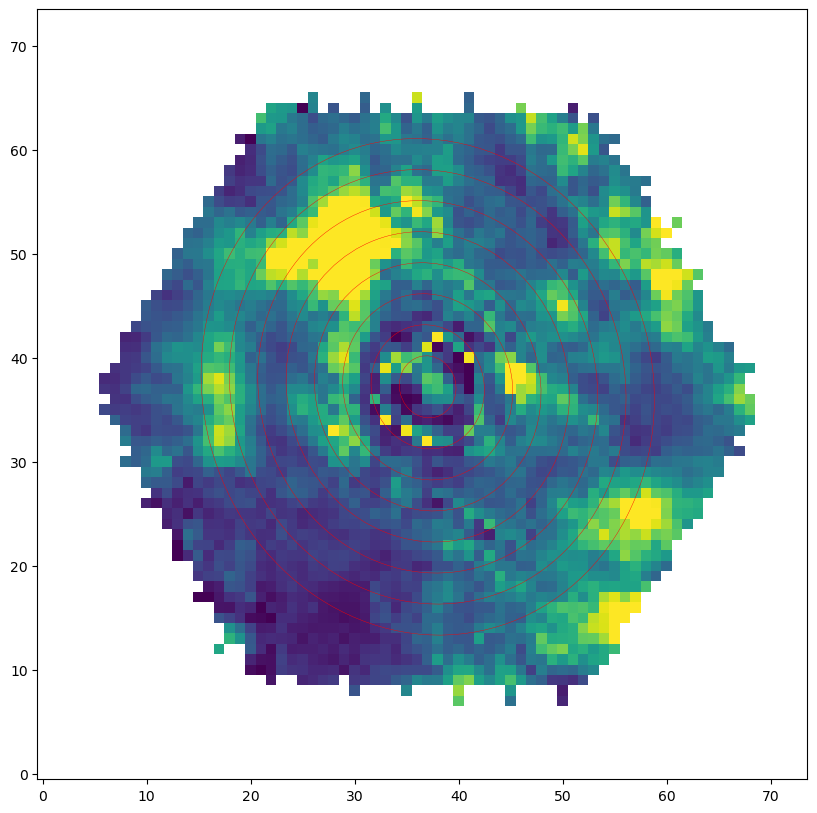

In [8]:
# To plot the data
plt.figure(figsize = [10, 10])
plt.imshow(att_data, 
           origin = 'lower', 
           vmin = 2, 
           vmax = 16)

# att_ellipse_flux = []
# att_nonzero_pixels = []
# att_ellipse_area = []

position = SkyCoord(x_c, y_c, frame = 'icrs', unit = 'deg')
att_axes_values = np.arange(step_size, 0.22, step_size)
    
for minor_axis in att_axes_values:
    a = minor_axis * u.arcminute
    b = a / axis_ratio 
    sky_aperture = SkyEllipticalAperture(position, a, b, theta * u.deg)
    pixel_aperture = sky_aperture.to_pixel(wcs = att_wcs)
    pixel_aperture.plot(color='red', lw=0.3)
#     mask = pixel_aperture.to_mask(method='center')
#     att_masked_data = mask.multiply(att_data)
#     # att_ellipse_flux.append(np.sum(att_masked_data))
    
#     phot_table = aperture_photometry(att_data, sky_aperture, wcs = att_wcs)    
#     att_ellipse_flux.append(phot_table['aperture_sum'].value[0])  
    
#     att_nonzero_pixels.append(np.sum(att_masked_data != 0))
#     att_ellipse_area.append(pixel_aperture.area)
    
plt.savefig('aperture_placement_IFU.png', 
            format = 'png', 
            bbox_inches = 'tight', 
            dpi = 150) 

In [ ]:
# To get average values within annuli.
z_annulus_array = np.diff(z_ellipse_flux)
z_annulus_array = np.insert(z_annulus_array, 0, z_ellipse_flux[0])

z_counts_array = np.diff(z_nonzero_pixels)
z_counts_array = np.insert(z_counts_array, 0, z_nonzero_pixels[0])
# averaged_z_annulus_array = z_annulus_array / z_counts_array

z_annulus_area = np.diff(z_ellipse_area)
z_annulus_area = np.insert(z_annulus_area, 0, z_ellipse_area[0])
averaged_z_annulus_array = z_annulus_array / z_annulus_area

att_annulus_array = np.diff(att_ellipse_flux)
att_annulus_array = np.insert(att_annulus_array, 0, att_ellipse_flux[0])

att_counts_array = np.diff(att_nonzero_pixels)
att_counts_array = np.insert(att_counts_array, 0, att_nonzero_pixels[0])
# averaged_att_annulus_array = att_annulus_array / att_counts_array

att_annulus_area = np.diff(att_ellipse_area)
att_annulus_area = np.insert(att_annulus_area, 0, att_ellipse_area[0])
averaged_att_annulus_array = att_annulus_array / att_annulus_area

# To plot data.  
fig, ax = plt.subplots()

x_values = axes_values[~np.isnan(averaged_z_annulus_array)]
y_values = averaged_z_annulus_array[~np.isnan(averaged_z_annulus_array)]

ax.plot(x_values, 
        y_values, 
        marker = '.', 
        color = 'k', label = 'F$_{NUV}$') 
        # linewidth = 1)

ax.plot(x_values[:len(averaged_att_annulus_array)], 
        y_values[:len(averaged_att_annulus_array)] * averaged_att_annulus_array / averaged_att_annulus_array[-1], 
        marker = '.', 
        color = 'k', linestyle = '--', label = 'F$_{NUV, corrected}$')
        # linewidth = 1)

# fontsize = 10

ticks = np.arange(tick_sep / one_arcmin_in_kpc, 
                  1.001 * till_here, 
                  tick_sep / one_arcmin_in_kpc) 

y_ticks = np.arange(4, 12, 2) * 1e-17
format_scentific = lambda x: np.format_float_scientific(x, precision=0, trim = '-')


ax.set_xlabel('kpc') #, fontsize = fontsize)
ax.set_xticks(ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(arcminute_to_kpc(ticks)) #, fontsize = fontsize)
ax.set_yticklabels(map(format_scentific, y_ticks))

# ax.yaxis.set_tick_params(labelsize = fontsize)
ax.set_ylabel('F$_{NUV}$ ($erg\ sec^{-1}\ cm^{-2}\ \AA^{-1}$)') #, fontsize = fontsize)

ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(ticks)
ax_top.set_xticklabels(np.around(ticks, 1)) #, fontsize = fontsize)
ax_top.set_xlabel('arcminutes')

ax_right = ax.secondary_yaxis('right')
ax_right.set_yticks(y_ticks)
ax_right.set_yticklabels(map(format_scentific, y_ticks * averaged_att_annulus_array[-1]))
ax_right.set_ylabel('F$_{NUV, corrected}$ ($erg\ sec^{-1}\ cm^{-2}\ \AA^{-1}$)')

# axx.axvspan(0, 6.2 / 60, color='yellow', alpha=0.5)
# axx.axvspan(0, 4.8 / 60, color='red', alpha=0.5)

ax.legend()


# set_size(fig, (13, 11))
fig.savefig(figname, 
            format = 'png', 
            bbox_inches = 'tight', 
            dpi = 150)

In [ ]:
plt.close('all')